In [1]:
# Latent Representations and Visualizations Week 4
# This version includes TFIDF, Word2Vec, Doc2Vec, LSA, and LDA code
# MSDS_453-DL
# jennifer.sleeman@northwestern.edu, (previous TA: paulhuynh2018@u.northwestern.edu)

In [2]:
!pip install seaborn
!pip install pyLDAvis
!pip install wordcloud


     ---------------------------------------- 2.6/2.6 MB 11.8 MB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
     --------------------------------------- 11.6/11.6 MB 11.9 MB/s eta 0:00:00
     --------------------------------------- 15.8/15.8 MB 15.2 MB/s eta 0:00:00
  Using cached tzdata-2023.4-py2.py3-none-any.whl (346 kB)
     ---------------------------------------- 14.9/14.9 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\opw477\\Anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



     -------------------------------------- 300.6/300.6 kB 6.2 MB/s eta 0:00:00


In [16]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from wordcloud import WordCloud

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim import similarities


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.models import LsiModel,LdaModel
import seaborn as sns

import numpy as np
import pyLDAvis
import pyLDAvis.gensim
import pickle 

import warnings
warnings.filterwarnings('ignore')
# Visualize the topics
pyLDAvis.enable_notebook()

In [17]:
#functions used to process text and create the required TFIDF and Doc2vec Matrices
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc


In [18]:
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names_out()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix, words

In [19]:
#This is code for Week 4.  The code will go consist of 4 sections as follows:
#1. Latent Semantic Analysis Example
#2. Latent Dirichlet Allocation
#3. Word2Vec Matrix creation

In [20]:

#Section 1: Latent Semantic Analysis Using Gensim's implementation
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index



In [21]:
#Section 1: Latent Semantic Analysis Example
def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)

    LSA.fit(tfidf_matrix)


    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])



In [22]:
#Section 2: Latent Dirichlet Allocation
def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

In [23]:
#Section 3: Word2Vec Matrix Generation
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    #words = list(model_w2v.wv.index_to_key)
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df


In [24]:
#this section of the code prepares the required variables to run functions set for each 
#section of code

#read in class corpus csv into python
data=pd.read_csv(r'C:\Users\opw477\OneDrive - Northwestern University\Desktop\MSDS_453\venv4\MSDS_453 files\movies1.csv')

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['content'].apply(lambda x: clean_doc(x))



#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['title'].tolist()
processed_text = data['processed_text'].tolist()


[(0, '0.567*"movie" + 0.232*"action" + 0.171*"story" + 0.163*"great" + 0.148*"movies" + 0.141*"characters" + 0.133*"really" + 0.129*"world" + 0.096*"think" + 0.093*"first"'), (1, '0.456*"movie" + 0.196*"action" + -0.178*"mahito" + -0.174*"parents" + -0.174*"mother" + -0.167*"miyazaki" + -0.127*"story" + -0.125*"world" + -0.117*"father" + -0.111*"would"'), (2, '0.504*"action" + -0.379*"movie" + 0.180*"willis" + 0.158*"great" + 0.154*"mcclane" + 0.126*"perfect" + 0.123*"story" + -0.122*"comedy" + 0.113*"bruce" + -0.110*"mafia"'), (3, '0.298*"miyazaki" + 0.229*"mahito" + -0.225*"mafia" + 0.198*"hayao" + -0.194*"comedy" + 0.162*"world" + -0.143*"parents" + 0.134*"mother" + -0.128*"kristin" + -0.112*"woman"'), (4, '0.289*"parents" + -0.280*"mafia" + -0.193*"comedy" + -0.173*"family" + 0.171*"harry" + -0.168*"kristin" + 0.141*"movie" + -0.119*"mamma" + -0.116*"action" + -0.110*"great"'), (5, '0.383*"barbie" + 0.193*"barbies" + 0.155*"stereotypical" + 0.148*"great" + 0.126*"movies" + 0.125*"a

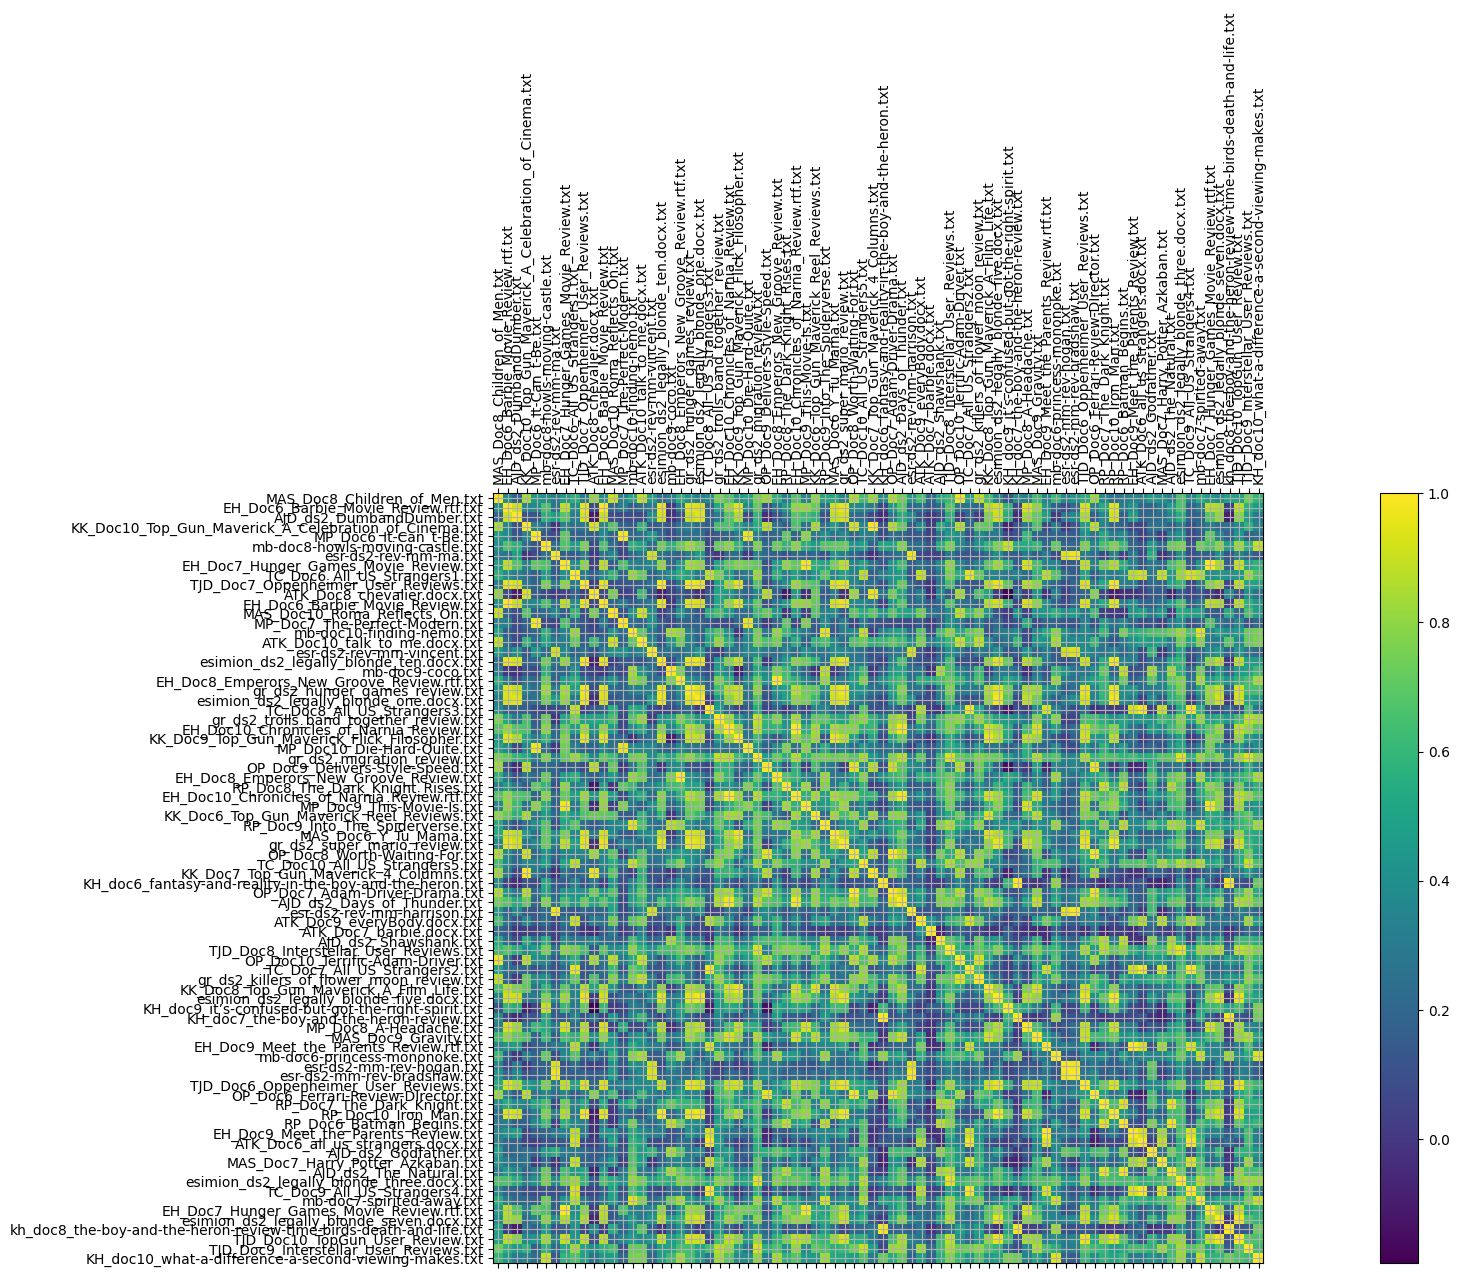

In [43]:
#run section 1
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=8
words=10
#####################################
model,dictionary,index=create_gensim_lsa_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow = dictionary.doc2bow(doc)
    vec_lsi = model[vec_bow]  # convert the query to LSI space
    sims = index[vec_lsi] # perform a similarity query against the corpus

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [26]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LDA model
        model = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary,chunksize=100, alpha='auto', eta='auto', iterations=400, passes=20, eval_every=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values



In [27]:
def plot_graph(doc_clean,start, stop, step):
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

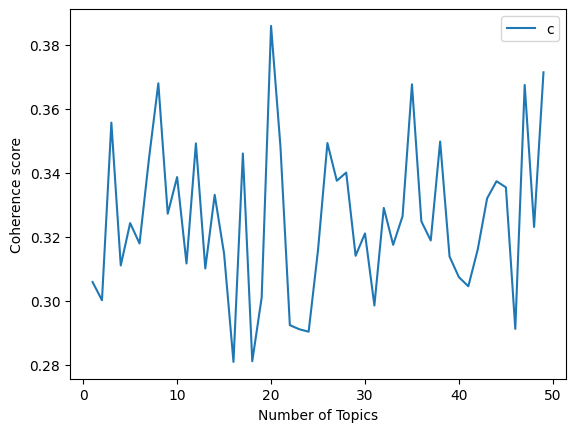

In [39]:
plot_graph(processed_text,1,50,1)

In [28]:

#Section 2:  Latent Dirichlet Allocation Using Gensim's implementation
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])



    return ldamodel,dictionary,index,doc_term_matrix



[(0, '0.003*"movie" + 0.002*"characters" + 0.002*"story" + 0.002*"movies" + 0.002*"never"'), (1, '0.004*"story" + 0.003*"movie" + 0.003*"first" + 0.003*"action" + 0.002*"characters"'), (2, '0.006*"parents" + 0.003*"movie" + 0.003*"stiller" + 0.003*"little" + 0.002*"every"'), (3, '0.014*"movie" + 0.004*"world" + 0.004*"would" + 0.004*"great" + 0.003*"movies"'), (4, '0.005*"movie" + 0.004*"parents" + 0.003*"action" + 0.003*"characters" + 0.003*"story"'), (5, '0.012*"movie" + 0.006*"story" + 0.005*"action" + 0.004*"really" + 0.004*"never"'), (6, '0.016*"movie" + 0.008*"action" + 0.005*"story" + 0.004*"movies" + 0.004*"really"'), (7, '0.009*"movie" + 0.004*"great" + 0.004*"story" + 0.004*"characters" + 0.003*"character"')]


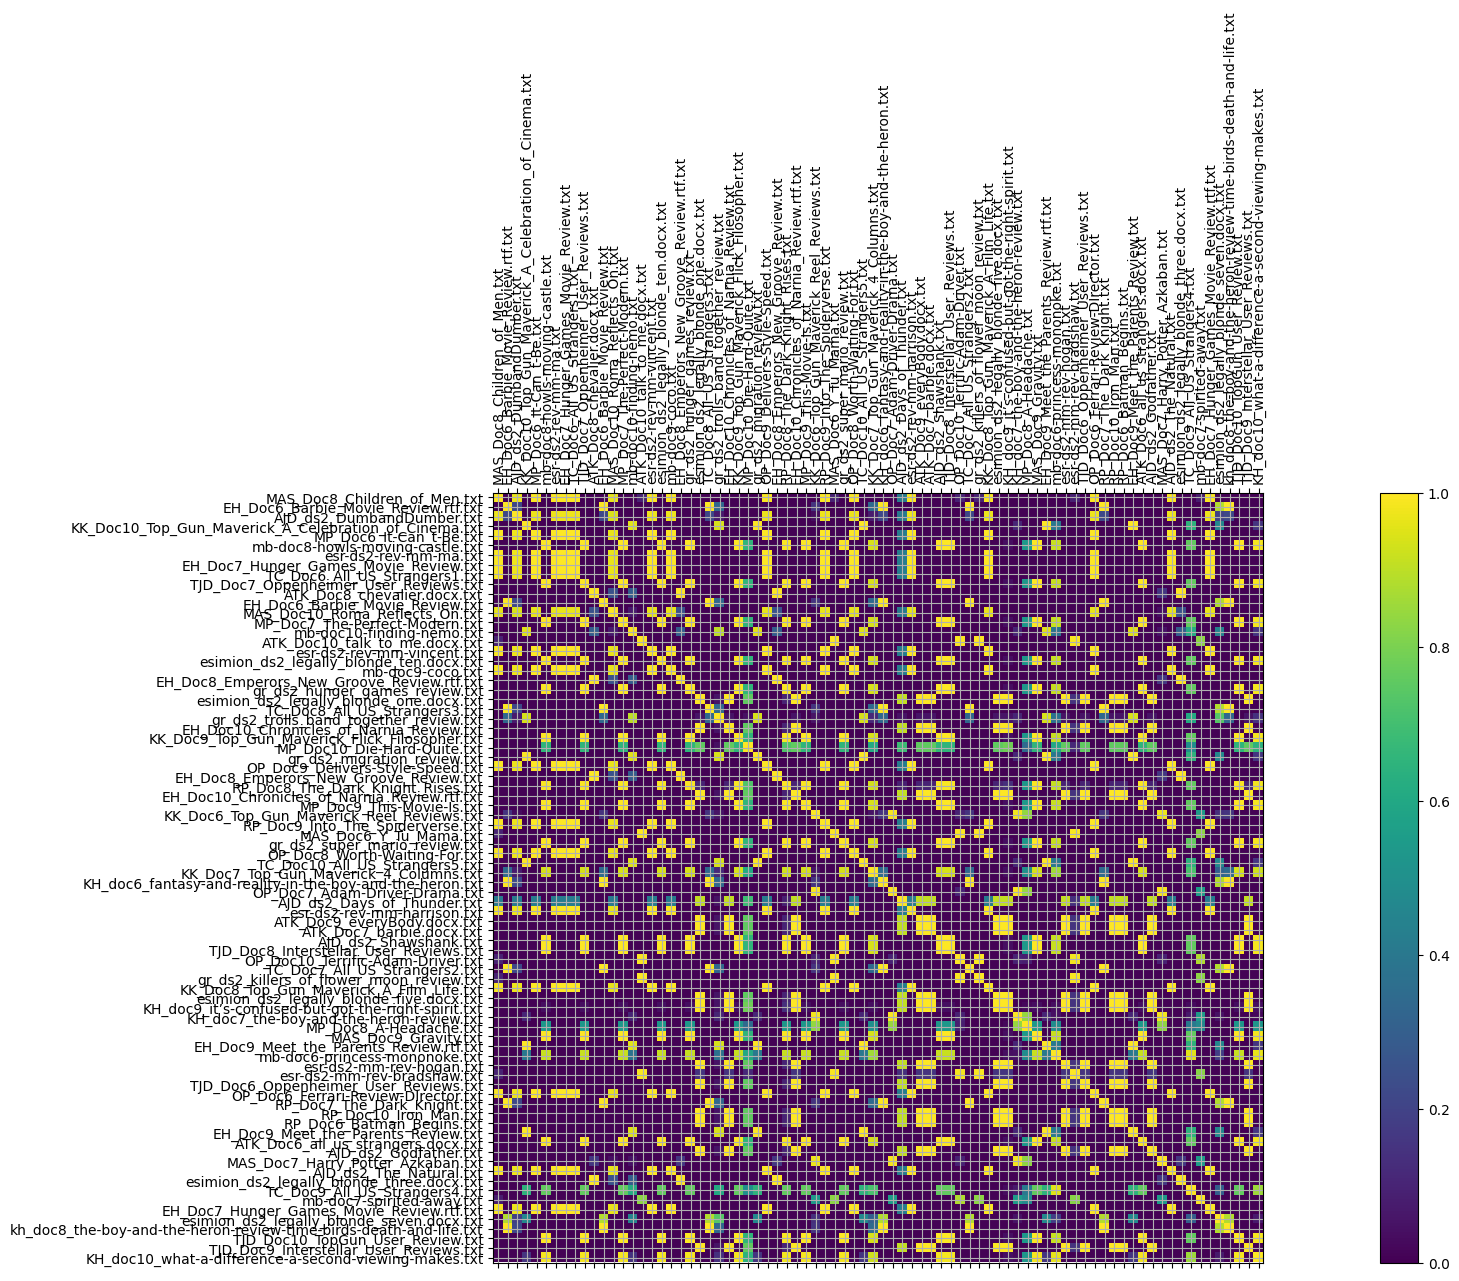

In [44]:
#run section 2
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=8
words=5
#####################################
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [45]:


LDAvis_prepared = pyLDAvis.gensim.prepare(model2, doctermmatrix2, dictionary2)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.038072  0.024429       1        1  22.213517
5      0.023822 -0.031116       2        1  20.489452
3      0.035907 -0.010034       3        1  17.526705
7     -0.002898  0.006769       4        1  10.290147
2     -0.017751  0.040937       5        1   8.535990
1     -0.027764 -0.019048       6        1   8.103037
4     -0.020381  0.004950       7        1   7.526151
0     -0.029007 -0.016886       8        1   5.315000, topic_info=         Term       Freq      Total Category  logprob  loglift
939   parents  25.000000  25.000000  Default  30.0000  30.0000
4187  stiller   7.000000   7.000000  Default  29.0000  29.0000
2498  ferrari  15.000000  15.000000  Default  28.0000  28.0000
2489   driver  10.000000  10.000000  Default  27.0000  27.0000
314     harry  12.000000  12.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
255     think   0.885782  30.263889   Topic8  -6.5614  -0.5966
651     going   0.790578  16.122354   Topic8  -6.6751  -0.0806
532     great   0.828610  35.830906   Topic8  -6.6281  -0.8322
1185  another   0.759668  16.754810   Topic8  -6.7150  -0.1589
459    really   0.769715  32.394162   Topic8  -6.7019  -0.8051

[615 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
264       3  0.468764  absurd
201       1  0.401344  acting
201       2  0.172005  acting
201       3  0.172005  acting
201       4  0.114670  acting
...     ...       ...     ...
1335      3  0.174124   young
1335      4  0.087062   young
1335      5  0.087062   young
1335      6  0.174124   young
1335      7  0.087062   young

[1125 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 4, 8, 3, 2, 5, 1])

In [31]:

#create tfidf matrix and doc2vec matrix
tfidf_matrix, terms = tfidf(final_processed_text, titles)


In [32]:
#run section 2
# Compare this implementation of lda with the gensim
# Any differences in behavior?
number_of_topics=30
words=10

lda(tfidf_matrix, terms, topics = number_of_topics, num_words = 10)


{0: 'barbie superhero freeman barbies prison stereotypical shawshank inmates leslie downey', 1: 'romantic maverick among decline generation deserves screened depiction innlthe epidemic', 2: 'white brief migration didnt theme luisa highly girls nugget mallards', 3: 'michael ending stranger wedding touch probably seemingly mafia sonny corleone', 4: 'mafia maverick carrey woman mamma lloyd kristin farrelly daniels buddy', 5: 'great story movies still family another right could elements making', 6: 'space joker thats youre dialog anarchy horrible wornout spinenlif chills', 7: 'strangers kristin mafia family sensitively delicate warmly amplify notesnljamie greet', 8: 'ferrari driver laura potter early yells professor italian accent woodley', 9: 'katniss peeta president mockingjay everdeen lawrence donald sutherland jennifer request', 10: 'mario ferrari pretty super comic story expectations members didnt games', 11: 'japanese witherspoon medical balance nature average cohen intersex miyazake

In [33]:
#run section 3
word2vec(processed_text, size = 100)

                   0         1         2         3         4         5   \
stoicism     0.008959 -0.008022 -0.002909 -0.008424  0.008910 -0.001851   
yikes        0.005792  0.001107 -0.001146  0.002291 -0.004255 -0.005820   
possibly    -0.009556 -0.002856 -0.002538 -0.004796  0.003149 -0.005342   
support      0.006553  0.008672  0.007314 -0.002230  0.004802 -0.003251   
surviving    0.000305  0.003724 -0.007544  0.008600  0.007894  0.006481   
...               ...       ...       ...       ...       ...       ...   
shoemaker   -0.003737 -0.003768 -0.005804 -0.009974  0.007935  0.007196   
intricacies -0.005283  0.004557  0.004684  0.003481  0.000979  0.001257   
flies       -0.005989  0.006952  0.002480  0.005456 -0.001913 -0.000827   
flamboyant  -0.007046  0.007491  0.006913  0.001607  0.005303  0.007646   
comedy       0.008788  0.008936  0.002112 -0.003576 -0.000243 -0.001368   

                   6         7         8         9   ...        90        91  \
stoicism    -0.0050

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
stoicism,0.008959,-0.008022,-0.002909,-0.008424,0.008910,-0.001851,-0.005071,0.009999,-0.006466,0.006948,...,0.001199,-0.005044,-0.003258,0.002335,-0.004505,-0.004466,0.007130,0.004100,-0.002614,0.005689
yikes,0.005792,0.001107,-0.001146,0.002291,-0.004255,-0.005820,0.002929,0.004362,0.007929,-0.007832,...,-0.005958,0.004433,-0.006323,0.003531,-0.002177,-0.007551,0.003174,0.002631,-0.009043,-0.005542
possibly,-0.009556,-0.002856,-0.002538,-0.004796,0.003149,-0.005342,-0.000941,0.009314,-0.004956,-0.001050,...,0.003910,-0.006468,-0.007887,-0.000358,-0.001390,-0.004064,-0.000367,-0.003675,-0.000313,-0.003049
support,0.006553,0.008672,0.007314,-0.002230,0.004802,-0.003251,-0.003628,0.001488,-0.000175,0.007797,...,0.007592,-0.002773,-0.008912,0.007682,-0.005937,-0.001596,0.009408,-0.006343,-0.004165,0.007774
surviving,0.000305,0.003724,-0.007544,0.008600,0.007894,0.006481,0.005654,0.008774,-0.009659,-0.005906,...,-0.001904,0.003490,-0.001696,0.008135,-0.002553,0.000648,-0.007561,-0.000249,0.009094,0.007645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
shoemaker,-0.003737,-0.003768,-0.005804,-0.009974,0.007935,0.007196,-0.000364,0.000176,0.004398,0.000870,...,-0.003682,0.007512,0.000439,-0.006025,-0.005622,-0.006586,-0.008242,0.005383,0.008278,-0.003398
intricacies,-0.005283,0.004557,0.004684,0.003481,0.000979,0.001257,0.002375,0.000633,-0.008339,0.006637,...,0.004167,-0.003031,-0.002527,-0.001330,-0.007461,0.005231,0.002464,-0.001913,-0.007750,0.003299
flies,-0.005989,0.006952,0.002480,0.005456,-0.001913,-0.000827,-0.007002,-0.008259,-0.001033,-0.008431,...,0.006062,-0.003115,-0.006753,0.000066,0.009323,-0.005123,-0.003759,-0.004075,0.003220,-0.005404
flamboyant,-0.007046,0.007491,0.006913,0.001607,0.005303,0.007646,-0.009150,-0.009787,-0.008743,0.000423,...,0.006474,-0.006674,0.000258,-0.001508,-0.002797,-0.002473,-0.005390,0.008403,-0.006930,0.009749


In [34]:
from scipy import linalg
tfidf_matrix

,aaron,abandoned,ability,abound,abounds,abroad,abrupt,absolute,absolutely,abstraction,...,youngest,youngster,younlnl,youre,youth,youve,yubaba,zegler,zimmers,zosia
MAS_Doc8_Children_of_Men.txt,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
EH_Doc6_Barbie_Movie_Review.rtf.txt,0.0,0.000000,0.107506,0.0,0.0,0.0,0.000000,0.0,0.112312,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
AJD_ds2_DumbandDumber.txt,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
KK_Doc10_Top_Gun_Maverick_A_Celebration_of_Cinema.txt,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.063412,0.0,0.0,0.0,0.0,0.0,0.0
MP_Doc6_It-Can_t-Be.txt,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
esimion_ds2_legally_blonde_seven.docx.txt,0.0,0.000000,0.058987,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
kh_doc8_the-boy-and-the-heron-review-time-birds-death-and-life.txt,0.0,0.058305,0.053122,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.07242,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
TJD_Doc10_TopGun_User_Review.txt,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.097581,0.0,0.0,0.0,0.0,0.0,0.0
TJD_Doc9_Interstellar_User_Reviews.txt,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.116785,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
from scipy.linalg import svd
U, S, Vt = svd(tfidf_matrix)


In [36]:
U.shape

(80, 80)

In [37]:
S.shape

(80,)

In [38]:
S

array([2.00169549e+00, 1.44045243e+00, 1.42074445e+00, 1.40641424e+00,
       1.39910212e+00, 1.36203637e+00, 1.32522469e+00, 1.30775830e+00,
       1.26576364e+00, 1.24000255e+00, 1.21920414e+00, 1.15416287e+00,
       1.12720729e+00, 1.10394945e+00, 1.09114423e+00, 1.07602780e+00,
       1.05822773e+00, 1.04945750e+00, 1.03717497e+00, 1.03051072e+00,
       1.02791765e+00, 1.02230015e+00, 1.01865158e+00, 1.01557746e+00,
       1.00975618e+00, 1.00638753e+00, 1.00395563e+00, 1.00251858e+00,
       9.96667935e-01, 9.95016023e-01, 9.89512877e-01, 9.88566141e-01,
       9.82983767e-01, 9.81637630e-01, 9.78672063e-01, 9.77504536e-01,
       9.69756961e-01, 9.66269398e-01, 9.62916293e-01, 9.59867019e-01,
       9.58490178e-01, 9.54404190e-01, 9.51863294e-01, 9.45589854e-01,
       9.44133934e-01, 9.40075594e-01, 9.35150431e-01, 9.29410192e-01,
       9.26523135e-01, 9.23168324e-01, 9.20939542e-01, 9.15303881e-01,
       9.06085906e-01, 9.03183810e-01, 9.02121239e-01, 9.00182344e-01,
      

In [39]:
Vt.shape

(5072, 5072)

In [40]:
svd = TruncatedSVD(n_components=15)
transformed = svd.fit_transform(tfidf_matrix)

print("Singular values:")
print(svd.singular_values_)

print("Transformed Matrix after reducing to 6 features:")
print(transformed)


Singular values:
[2.0016952  1.44027361 1.4203699  1.40604906 1.39880187 1.36120737
 1.32394737 1.30689797 1.26255363 1.23619882 1.21409618 1.14859283
 1.11801886 1.07829235 1.07324569]
Transformed Matrix after reducing to 6 features:
[[ 0.14513545 -0.0198169  -0.0311731  ... -0.1074382   0.22332383
   0.017062  ]
 [ 0.36155746  0.28527521 -0.05782877 ... -0.06747712 -0.02039896
   0.05553351]
 [ 0.19235207  0.01474278 -0.02547184 ...  0.15173627  0.13543336
  -0.13344372]
 ...
 [ 0.30632881  0.02815545  0.04135959 ... -0.02611427 -0.11756836
  -0.07516696]
 [ 0.17307374 -0.00874213  0.0065812  ... -0.13288959  0.29708805
   0.10898537]
 [ 0.31348188 -0.00351068  0.10822334 ... -0.0086828  -0.09204301
  -0.17206015]]


In [41]:
for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])



Topic 0: 
movie
action
great
story
think
parents
movies
Topic 1: 
peeta
katniss
president
mockingjay
movie
action
ridiculous
Topic 2: 
emperors
groove
disney
making
although
think
world
Topic 3: 
movie
women
experience
things
crazy
creativity
agree
Topic 4: 
narnia
rings
startlingly
timeless
casting
battle
heart
Topic 5: 
stiller
parents
narnia
rings
startlingly
former
casting
Topic 6: 
mafia
kristin
comedy
mamma
woman
collette
italian
Topic 7: 
ferrari
mahito
women
things
mother
barbie
miyazaki
Topic 8: 
miyazaki
mahito
mother
mafia
comedy
hayao
kristin
Topic 9: 
ferrari
driver
stiller
laura
mahito
miyazaki
piero
Topic 10: 
maverick
cruise
pilot
mission
original
cameras
actors
Topic 11: 
action
willis
mcclane
mahito
rickman
bruce
mother
Topic 12: 
witherspoon
movie
reese
harvard
blonde
legally
usual
Topic 13: 
space
cuaron
potter
gravity
behind
woman
harry
Topic 14: 
witherspoon
reese
average
harvard
order
usual
perfect
